<h1><font color="#113D68" size=6>Tema 4 - Sistemas Multiagentes</font></h1>

<h1><font color="#113D68" size=5>Ampliación de Sistemas Inteligentes (CÓDIGO 71014069)</font></h1>

<h1><font color="#113D68" size=4>1. Agentes Inteligentes y Arquitecturas</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
</div>


---

**Objetivo.** Comprender y comparar, de forma visual y experimental, **agentes reactivos**, **deliberativos** e **híbridos** en un entorno 2D sencillo (tipo *vacuum world* / rescate de objetos), midiendo **eficiencia**, **tiempo de decisión** y **adaptabilidad** ante cambios en el entorno.

**Qué aporta este cuaderno**
- Definiciones operativas: **agente**, **entorno**, **percepción**, **acción**, **autonomía**, **racionalidad**.
- Implementaciones mínimas de tres **arquitecturas**:
  - **Reactiva**: reglas estímulo–acción (subsumption-lite).
  - **Deliberativa**: planificación (A*) hacia metas.
  - **Híbrida**: capa reactiva cercana + capa deliberativa para trayectos.
- Experimento comparativo con:
  - **Mapa de calor** de visitas por celda.
  - **Curva anytime** de celdas limpias / objetos recogidos.
  - **Coste/tiempo de decisión** por *tick* y métricas agregadas.

> **Lectura teórica**: Libro base, cap. 20, secciones **20.1–20.2.3**.  
> **Preguntas típicas de examen**: diferencias y trade-offs entre arquitecturas; cuándo preferir reactivo vs deliberativo; papel del componente híbrido; noción de racionalidad (adecuación entre objetivos, sensores/actuadores y entorno).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappush, heappop
from time import perf_counter
rng = np.random.default_rng(7)

def set_seed(s=7):
    global rng
    rng = np.random.default_rng(s)

# Vecindad 4 (arriba, abajo, izq, dcha)
DIRS = [(-1,0),(1,0),(0,-1),(0,1)]
def in_bounds(p, H, W): 
    r,c = p; return 0<=r<H and 0<=c<W

def manhattan(a,b): 
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

---

<a id="indice"></a>
# <font color="#004D7F" size=6>Índice</font>

1. [Entorno 2D](#intro)
2. [Planificador A* (para agentes deliberativos / capa alta de híbrido](#api)
3. [Agentes](#algos)
4. [Bucle de simulación y métricas](#obj)
5. [Visualizaciones](#single)
6. [Estudio repetido (robustez): medias y boxplots](#multirun)
7. [Experimento de adaptabilidad (cambio en mitad del episodio)](#bench)
8. [Conclusiones](#vis2d)

---

<a id="intro"></a>
# <font color="#004D7F" size=6>1. Entorno 2D</font>

Esta sección define el **entorno base 2D** donde operarán los distintos tipos de agentes. Su finalidad es proporcionar un **escenario controlado, dinámico y reproducible** para evaluar el comportamiento de cada arquitectura (reactiva, deliberativa e híbrida) bajo las mismas condiciones.

**Propósito general:**
- Representar un entorno **discreto** con obstáculos, celdas transitables y objetivos distribuidos aleatoriamente.
- Servir como **banco de pruebas unificado** para medir eficiencia, adaptabilidad y capacidad de reacción de los agentes.

**Características principales:**
- **Generación aleatoria reproducible:** mediante una semilla, crea el mapa inicial con obstáculos (`1`), espacios libres (`0`) y objetivos (`2`).
- **Interacción con el entorno:** funciones para detectar si una celda es libre o contiene un objetivo, así como para "recogerlo" (`step_clean`).
- **Vecindad y exploración:** permite consultar las celdas vecinas accesibles, facilitando la navegación y planificación.
- **Entorno dinámico:** la función `inject_change` introduce alteraciones (nuevos obstáculos o reubicación de objetivos) durante la simulación, lo que permite analizar la **robustez** de los agentes ante cambios no previstos.

> En conjunto, este bloque proporciona la **infraestructura ambiental** sobre la que se evaluará la inteligencia y adaptabilidad de los diferentes tipos de agentes.

In [2]:
class GridEnv:
    def __init__(self, H=12, W=18, p_block=0.10, n_targets=12, seed=7):
        self.H, self.W = H, W
        self.p_block, self.n_targets = p_block, n_targets   # <- guardar
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.map = np.zeros((H, W), dtype=int)  # 0 libre, 1 obstáculo, 2 objetivo
        mask = self.rng.random((H, W)) < p_block
        self.map[mask] = 1

        self.targets = set()
        while len(self.targets) < n_targets:
            r = self.rng.integers(0, H); c = self.rng.integers(0, W)
            if self.map[r, c] == 0:
                self.map[r, c] = 2; self.targets.add((r, c))

        while True:
            r = self.rng.integers(0, H); c = self.rng.integers(0, W)
            if self.map[r, c] == 0:
                self.start = (r, c); break

    def reset(self):
        # <- ahora respeta p_block, n_targets y seed originales
        self.__init__(self.H, self.W, self.p_block, self.n_targets, self.seed)

    # utilidades previas se mantienen (is_free, is_target, etc.)

    def snapshot(self):
        """Copia profunda del estado inicial para dibujar rutas ideales."""
        return {
            "H": self.H, "W": self.W,
            "p_block": self.p_block, "n_targets": self.n_targets, "seed": self.seed,
            "map": self.map.copy(),
            "targets": set(self.targets),
            "start": tuple(self.start),
        }

    def is_free(self, p): 
        r,c=p; return self.map[r,c]!=1

    def is_target(self, p):
        r,c=p; return self.map[r,c]==2

    def step_clean(self, p):
        r,c=p
        if self.map[r,c]==2:
            self.map[r,c]=0
            self.targets.discard((r,c))
            return 1
        return 0

    def neighbors_free(self, p):
        H,W=self.H,self.W
        for dr,dc in DIRS:
            q=(p[0]+dr,p[1]+dc)
            if in_bounds(q,H,W) and self.is_free(q):
                yield q

    def inject_change(self, frac_new_blocks=0.06, move_k=3):
        free = [(r,c) for r in range(self.H) for c in range(self.W) if self.map[r,c]==0]
        self.rng.shuffle(free)
        for (r,c) in free[:int(len(free)*frac_new_blocks)]:
            self.map[r,c]=1
        remaining = list(self.targets)
        self.rng.shuffle(remaining)
        moved=0
        for p in remaining:
            if moved>=move_k: break
            self.map[p]=0; self.targets.discard(p)
            while True:
                r = self.rng.integers(0,self.H); c = self.rng.integers(0,self.W)
                if self.map[r,c]==0:
                    self.map[r,c]=2; self.targets.add((r,c))
                    moved+=1; break

### **Visualización rápida del entorno**

Para inspeccionar el mapa (celdas libres, obstáculos, objetivos) y la posición inicial del agente, usa esta utilidad de trazado. Es útil para verificar que la **semilla** y los parámetros generan escenarios razonables antes de lanzar las simulaciones.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_env(env, title="Entorno (GridEnv)"):
    """
    Muestra el grid con:
      - 1: obstáculos (negro)
      - 2: objetivos  (amarillo)
      - 0: libres     (blanco)
    Marca la posición inicial del agente con un punto azul.
    """
    # Mapa de colores simple (0 libre, 1 obstáculo, 2 objetivo)
    cmap = plt.cm.get_cmap('gray', 3)  # base gris
    # Construimos una matriz RGB manualmente para colores personalizados
    color_map = np.zeros((*env.map.shape, 3), dtype=float)
    color_map[env.map == 0] = [1.0, 1.0, 1.0]  # blanco libres
    color_map[env.map == 1] = [0.0, 0.0, 0.0]  # negro obstáculos
    color_map[env.map == 2] = [1.0, 0.85, 0.2] # amarillo objetivos

    plt.figure(figsize=(6.8, 4.6))
    plt.imshow(color_map, interpolation='none', origin='upper')
    # Posición inicial
    r0, c0 = env.start
    plt.scatter([c0], [r0], s=80, marker='o', edgecolors='k', facecolors='royalblue', label='Inicio')

    # Cuadrícula ligera
    H, W = env.map.shape
    for r in range(H+1):
        plt.axhline(r-0.5, color='k', lw=0.3, alpha=0.2)
    for c in range(W+1):
        plt.axvline(c-0.5, color='k', lw=0.3, alpha=0.2)

    # Leyenda
    legend_elems = [
        Patch(facecolor='white', edgecolor='k', label='Libre (0)'),
        Patch(facecolor='black', edgecolor='k', label='Obstáculo (1)'),
        Patch(facecolor=(1.0, 0.85, 0.2), edgecolor='k', label='Objetivo (2)'),
        Patch(facecolor='royalblue', edgecolor='k', label='Inicio (•)')
    ]
    plt.legend(handles=legend_elems, loc='upper right', framealpha=0.9)

    plt.title(title)
    plt.xticks(range(0, W, max(1, W//10)))
    plt.yticks(range(0, H, max(1, H//10)))
    plt.tight_layout()
    plt.show()

/var/folders/9h/d3b8zc6j5019cyvmb_h929xm0000gn/T/ipykernel_5687/4160549552.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gray', 3)  # base gris


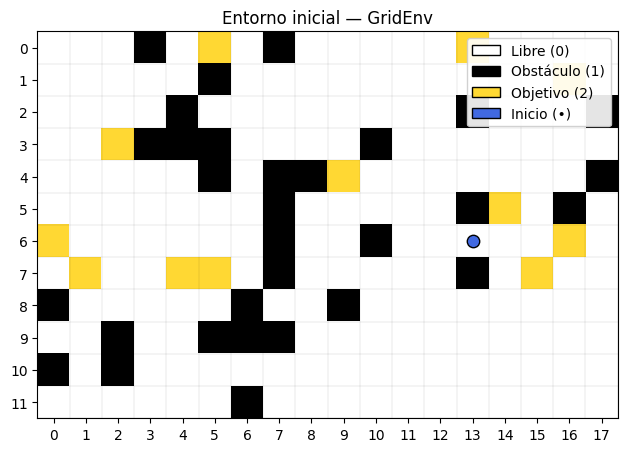

In [4]:
# Crear un entorno de prueba
env = GridEnv(H=12, W=18, p_block=0.15, n_targets=12, seed=21)

# Mostrar visualización del entorno inicial
plot_env(env, title="Entorno inicial — GridEnv")

#### **Interpretación del entorno inicial — *GridEnv***

La figura representa una cuadrícula de **12×18** celdas donde:
- Las celdas **blancas** son zonas transitables (*libres*),  
- Las **negras** son **obstáculos**,  
- Las **amarillas** son **objetivos**, y  
- El punto **azul** indica la **posición inicial del agente**.

El entorno generado (semilla 7) presenta una **distribución equilibrada de obstáculos y objetivos**, creando pasillos y bloqueos parciales que obligan al agente a **planificar rutas alternativas**.  
Es un escenario idóneo para comparar comportamientos:
- El **agente reactivo** tenderá a seguir estímulos locales.  
- El **deliberativo** planificará trayectorias globalmente más eficientes.  
- El **híbrido** combinará planificación y reacción ante cambios.

> En conjunto, el mapa define un entorno reproducible y de complejidad moderada, adecuado para analizar diferencias en **eficiencia, adaptabilidad y tiempo de decisión** entre las tres arquitecturas de agentes.

El siguiente bloque muestra el **mismo grid (12×18)** después de aplicar
`inject_change(frac_new_blocks=0.08, move_k=4)`:
- Se han **añadido nuevos obstáculos** (≈8% de las celdas libres), visibles como **bloques negros** adicionales.
- Se han **reubicado 4 objetivos** (celdas **amarillas**) a posiciones distintas.
- La posición inicial (punto **azul**) no cambia, pero **corredores** que antes eran transitables ahora pueden estar **cortados** o **estrechados**.

/var/folders/9h/d3b8zc6j5019cyvmb_h929xm0000gn/T/ipykernel_5687/4160549552.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gray', 3)  # base gris


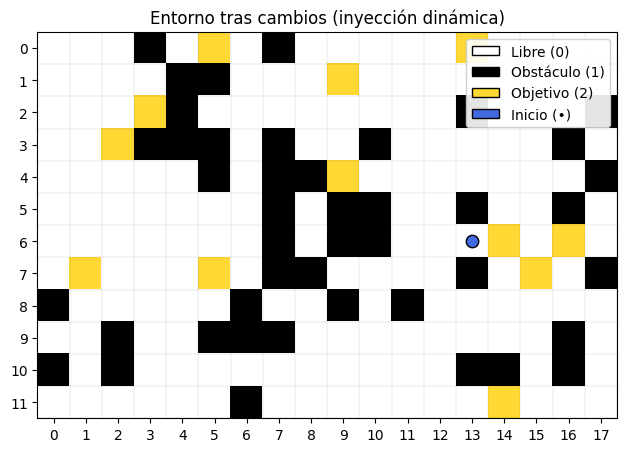

In [5]:
# Introducir cambios dinámicos en el entorno
env.inject_change(frac_new_blocks=0.08, move_k=4)

# Visualizar entorno tras los cambios
plot_env(env, title="Entorno tras cambios (inyección dinámica)")

#### **Interpretación — Entorno tras cambios dinámicos**

**Diferencias respecto al entorno inicial**
- Mayor **congestión** en algunas columnas/filas (p. ej., bandas negras más largas).
- **Objetivos desplazados**: aparecen en zonas que antes estaban vacías, modificando las rutas “óptimas”.
- Aumenta la **necesidad de replanificación**: planes válidos en el mapa original pueden quedar **inviables**.

**Lectura didáctica**
- Este escenario sirve para evaluar **adaptabilidad**:
  - El **reactivo** puede atascarse o desviarse con facilidad.
  - El **deliberativo** debe **recalcular** rutas (p. ej., A* desde la posición actual).
  - El **híbrido** combina reacción local con **replanificación puntual**, ofreciendo generalmente la **mejor resiliencia**.

---

<a id="api"></a>
# <font color="#004D7F" size=6>2. Planificador A* (para agentes deliberativos / capa alta de híbrido)</font>

Este bloque implementa el **algoritmo de planificación A\*** dentro del entorno `GridEnv`.  
Su función es **encontrar la ruta óptima (mínima distancia Manhattan)** entre una posición inicial (`start`) y un objetivo (`goal`), evitando obstáculos.

**Propósito dentro del notebook:**
- Permitir que los **agentes deliberativos e híbridos** planifiquen rutas globales eficientes basadas en conocimiento del entorno.  
- Servir como componente cognitivo dentro del **razonamiento simbólico** de los agentes deliberativos.

**Características clave del código:**
- Usa una **cola de prioridad (heap)** ordenada por el coste estimado `f = g + h`, donde:
  - `g` es el coste acumulado desde el inicio,
  - `h` es la heurística, calculada como la **distancia Manhattan** entre el nodo actual y el objetivo.
- El diccionario `parent` reconstruye la ruta una vez alcanzado el destino.
- La función retorna una **lista ordenada de coordenadas (ruta óptima)** o `None` si no existe camino posible.

**Contexto teórico:**
- A\* representa la **base del razonamiento deliberativo**, pues permite **planificación informada y óptima** bajo un modelo explícito del entorno.
- En contraste con el agente reactivo, que actúa localmente, A\* le da al agente deliberativo la capacidad de **anticipar secuencias de acciones** y **recalcular planes** ante cambios dinámicos.

In [6]:
def astar_path(env: GridEnv, start, goal):
    if start==goal: return [start]
    H,W=env.H,env.W
    openL=[]; heappush(openL,(manhattan(start,goal),0,start,None))
    best_g={start:0}; parent={}
    while openL:
        f,g,p,par = heappop(openL)
        parent[p]=par
        if p==goal:
            path=[]; cur=p
            while cur is not None:
                path.append(cur); cur=parent[cur]
            return list(reversed(path))
        for q in env.neighbors_free(p):
            g2=g+1
            if g2<best_g.get(q,1e9):
                best_g[q]=g2
                heappush(openL,(g2+manhattan(q,goal),g2,q,p))
    return None  # sin ruta

---

<a id="algos"></a>
# <font color="#004D7F" size=6>3. Agentes</font>

<a id="algos"></a>
# <font color="#004D7F" size=5>3.1. Reactivo (reglas estímulo–acción)</font>

**Qué modela.** Un agente de **arquitectura reactiva** (tipo subsunción): decide en cada paso solo con **percepciones locales** y reglas simples, sin planificar rutas ni mantener un modelo global del entorno.

**Cómo decide.**
1. **Si está sobre un objetivo**, lo recoge (`step_clean`) y permanece en la celda.
2. **Búsqueda local de objetivos** en un **radio 2** alrededor de su posición.  
   - Si encuentra alguno, elige el **vecino libre** que **minimiza la distancia Manhattan** al objetivo más cercano (**greedy local**).
3. **Si no hay objetivos cercanos**, explora: toma un vecino libre con **sesgo a “seguir pared”** (prefiere celdas con más obstáculos alrededor para no quedar en medio de áreas abiertas).

**Características y propósito.**
- **Sin memoria** (salvo la posición actual) y **sin planificación**: coste de decisión muy bajo ⇒ útil como **baseline**.
- **Reacciona bien** a cambios locales (obstáculos/objetivos que aparecen cerca).
- **Limitaciones**: puede **atascarse** en callejones o tomar trayectorias muy subóptimas en entornos con pasillos largos; no anticipa desvíos.

**Relación con la teoría (Tema 4, cap. 20).**
- Representa la familia de **agentes puramente reactivos**: mapeo percepción→acción, **sin estado interno** ni razonamiento simbólico.
- Sirve para comparar con los agentes **deliberativo** e **híbrido**, destacando el trade-off clásico: **bajo coste de decisión** vs **falta de óptimo global**.

In [7]:
class ReactiveAgent:
    name="Reactive"
    def __init__(self): 
        self.reset()
    def reset(self):
        self.pos=None
    def set_start(self, p): 
        self.pos=p
    def decide(self, env: GridEnv):
        # Clean si hay objetivo
        if env.is_target(self.pos): 
            got = env.step_clean(self.pos)
            return self.pos, got, 0.0
        # Buscar objetivo cercano en radio 2
        t0=perf_counter()
        H,W=env.H,env.W
        candidates=[]
        for r in range(max(0,self.pos[0]-2), min(H, self.pos[0]+3)):
            for c in range(max(0,self.pos[1]-2), min(W, self.pos[1]+3)):
                if env.map[r,c]==2: candidates.append((r,c))
        move=self.pos
        if candidates:
            goal=min(candidates, key=lambda q: manhattan(self.pos,q))
            # elegir vecino que acerque (greedy local)
            best=None; bestd=1e9
            for q in env.neighbors_free(self.pos):
                d=manhattan(q,goal)
                if d<bestd: bestd=d; best=q
            move = best if best is not None else self.pos
        else:
            # exploración con sesgo: intenta seguir pared
            neigh=list(env.neighbors_free(self.pos))
            if neigh:
                rng.shuffle(neigh)
                move = min(neigh, key=lambda q: sum(env.map[n]==1 for n in env.neighbors_free(q)))
        self.pos=move
        dt=perf_counter()-t0
        return self.pos, 0, dt

<a id="algos"></a>
# <font color="#004D7F" size=5>3.2. Deliberativo (planificación A*)</font>

**Qué modela.**  
Este bloque define un **agente deliberativo**, basado en el paradigma **razonamiento–planificación–ejecución**, que emplea el algoritmo **A\*** para planificar rutas óptimas hacia los objetivos dentro del entorno `GridEnv`.

**Comportamiento general.**
1. El agente **mantiene un modelo interno del entorno** (la cuadrícula) y su posición actual.  
2. En cada ciclo de decisión:
   - **Si se encuentra sobre un objetivo**, lo recoge (acción inmediata).  
   - Si **no tiene plan**, busca el **objetivo más cercano** y ejecuta **A\*** (`astar_path`) para generar un **plan completo** (secuencia de posiciones).  
   - **Ejecución del plan:** se mueve paso a paso según la ruta calculada.  
   - Si el entorno cambia (obstáculos nuevos o desplazamiento de objetivos), el plan puede quedar obsoleto y el agente deberá **replanificar**.
3. Devuelve la nueva posición, el número de objetivos recogidos y el tiempo de decisión.

**Características destacadas.**
- Planificación global: busca soluciones **óptimas en distancia** gracias al uso de **A\***.
- Coste computacional más alto: cada decisión implica **búsqueda en el espacio de estados**, lo que lo hace **más lento pero racional**.
- Alta sensibilidad a cambios: si el entorno se altera, debe **recalcular el plan completo**, lo que refleja la **rigidez** de los agentes puramente deliberativos.

**Relación con la teoría (Tema 4, cap. 20 del libro base).**
- Este agente encarna el **modelo deliberativo clásico**, donde las acciones se derivan de una **planificación simbólica** sobre un modelo interno.  
- Muestra la diferencia esencial frente al reactivo: mientras el primero **responde**, el segundo **razona y planifica**.  
- Se vincula con los conceptos de **racionalidad, representación del entorno y toma de decisiones basadas en objetivos**.

> En síntesis, este agente ejemplifica cómo el razonamiento simbólico y la planificación óptima dotan al sistema de **capacidad de anticipación**, a costa de **menor adaptabilidad** ante cambios súbitos en el entorno.

In [8]:
class DeliberativeAgent:
    name="Deliberative(A*)"
    def __init__(self): self.reset()
    def reset(self):
        self.pos=None; self.path=[]; self.goal=None
    def set_start(self, p): self.pos=p
    def decide(self, env: GridEnv):
        # si hay objetivo: limpiar
        if env.is_target(self.pos):
            got=env.step_clean(self.pos)
            self.path=[]; self.goal=None
            return self.pos, got, 0.0
        t0=perf_counter()
        # si no hay plan o la meta ya no existe ⇒ replan
        if not self.path or (self.goal not in env.targets):
            if not env.targets:
                return self.pos, 0, 0.0
            self.goal = min(env.targets, key=lambda q: manhattan(self.pos,q))
            self.path = astar_path(env, self.pos, self.goal) or []
        # avanzar un paso si hay camino
        if len(self.path)>=2:
            self.pos=self.path[1]
            self.path=self.path[1:]
        dt=perf_counter()-t0
        return self.pos, 0, dt

<a id="algos"></a>
# <font color="#004D7F" size=5>3.3. Híbrido</font>

**Qué modela.**  
Este bloque implementa un **agente híbrido** que integra dos capas:  
1) una **capa deliberativa** que planifica con **A\*** rutas hacia una meta, y  
2) una **capa reactiva** que toma **micro-decisiones locales** cuando el plan queda desfasado (bloqueos, cambios súbitos del entorno).

**Cómo decide.**  
- **Si está sobre un objetivo**, lo recoge y limpia el plan.  
- **Selección de meta**: elige la meta más cercana (distancia Manhattan).  
- **Planificación**: si no hay plan (o la meta cambió), calcula una ruta con `A*`.  
- **Ejecución del plan**: avanza al siguiente paso siempre que siga **libre**.  
- **Fallback reactivo**: si el siguiente paso está bloqueado, realiza un **paso reactivo** (mueve a la celda vecina que reduce la distancia a la meta o, sin meta, la de mayor “libertad”) y luego **replanifica corto** desde la nueva posición.

**Ventajas y trade-offs.**  
- **Robustez a cambios**: no se “rompe” ante obstáculos nuevos porque puede reaccionar localmente.  
- **Eficiencia**: conserva la **orientación global** del deliberativo pero evita recalcular planes completos en cada perturbación.  
- **Coste moderado**: alterna planificación y pasos reactivos, logrando menor latencia de decisión que un deliberativo puro.

**Vínculo con la teoría (Tema 4, cap. 20).**  
- Representa las **arquitecturas en capas** típicas (reactiva + deliberativa), donde la capa inferior gestiona contingencias de corto plazo y la superior aporta **intencionalidad** y **búsqueda dirigida**.  
- Es un patrón clásico para entornos **dinámicos**: mantiene rendimiento cercano al óptimo en estático y **degrada con gracia** cuando el entorno cambia.

In [9]:
class HybridAgent:
    name="Hybrid"
    def __init__(self): self.reset()
    def reset(self):
        self.pos=None; self.plan=[]; self.goal=None
    def set_start(self, p): self.pos=p
    def _reactive_step(self, env):
        neigh = list(env.neighbors_free(self.pos))
        if not neigh: return self.pos
        # elige vecino que más reduzca distancia a la meta; si no hay meta, el de mayor libertad
        if self.goal:
            return min(neigh, key=lambda q: manhattan(q,self.goal))
        return max(neigh, key=lambda q: sum(1 for _ in env.neighbors_free(q)))
    def decide(self, env: GridEnv):
        if env.is_target(self.pos):
            got=env.step_clean(self.pos)
            self.plan=[]; self.goal=None
            return self.pos, got, 0.0
        t0=perf_counter()
        # (re)selección de meta si no hay plan
        if not self.plan or (self.goal not in env.targets):
            if env.targets:
                self.goal = min(env.targets, key=lambda q: manhattan(self.pos,q))
                self.plan = astar_path(env, self.pos, self.goal) or []
        # intentar seguir plan; si bloqueado => paso reactivo y replan corto
        moved=False
        if len(self.plan)>=2:
            nxt = self.plan[1]
            if env.is_free(nxt):
                self.pos = nxt
                self.plan = self.plan[1:]
                moved=True
        if not moved:   # micro-reacción
            self.pos = self._reactive_step(env)
            # replan corto
            if self.goal:
                sub = astar_path(env, self.pos, self.goal)
                self.plan = sub or []
        dt=perf_counter()-t0
        return self.pos, 0, dt

---

<a id="obj"></a>
# <font color="#004D7F" size=6>4. Bucle de simulación y métricas</font>

**Propósito.**  
Esta sección ejecuta un **episodio completo** de interacción *agente–entorno* durante `T` pasos, registra el comportamiento y devuelve **métricas comparables** entre arquitecturas.

**Qué hace el bucle.**
- **Inicializa** el entorno (`reset`) y el agente (`reset`, `set_start`).
- En cada paso:
  1) (Opcional) **inyecta cambios** en el entorno en `t == T_change` (nuevos obstáculos y metas movidas) para evaluar **adaptabilidad**.  
  2) Llama a `agent.decide(env)`, que devuelve la **nueva posición**, si **recogió un objetivo** (`inc`) y el **tiempo de decisión** (`dt`).
  3) **Actualiza contadores**: trayectoria (`path`), mapa de **visitas** (heatmap), acumulado de objetivos `got` y lista de tiempos de decisión.

**Métricas devueltas (para comparar agentes).**
- `got`: número total de **objetivos recogidos** (eficacia).  
- `mean_decision_time`: **tiempo medio de decisión** por paso (latencia computacional).  
- `distance`: **distancia Manhattan total recorrida** (eficiencia de ruta).  
- `visits`: matriz con **nº de veces** que el agente visitó cada celda (para heatmaps).  
- `path`: **secuencia de posiciones** (para trazar la trayectoria).

**Lectura didáctica.**  
- `got` mide **logro de objetivos**; `distance` y `mean_decision_time` miden **coste**.  
- Con `T_change`, se observa cómo **degradan** o **se recuperan** las arquitecturas ante cambios (p. ej., si el plan queda inválido, si el reactivo se atasca, si el híbrido replanifica rápido).  
- `visits` y `path` permiten **visualizar patrones**: exploración caótica (reactivo), pasillos planificados (deliberativo), y combinaciones adaptativas (híbrido).

In [10]:
def simulate(agent, env: GridEnv, T=300, T_change=150, seed=7, heatmap=True):
    set_seed(seed)
    #env.reset() #Importante: si se quieren hacer diferentes entornos quitar comentario
    agent.reset()
    agent.set_start(env.start)
    pos_hist=[env.start]
    visits=np.zeros_like(env.map, dtype=int)
    visits[env.start]+=1
    got=0; tcosts=[]
    for t in range(T):
        if t==T_change:
            env.inject_change(frac_new_blocks=0.08, move_k=4)
            # reset ruta si deliberativo/híbrido lo desea
        p, inc, dt = agent.decide(env)
        got += inc
        pos_hist.append(p)
        visits[p]+=1
        tcosts.append(dt)
    dist=sum(manhattan(a,b) for a,b in zip(pos_hist[:-1], pos_hist[1:]))
    return {
        "got": got,
        "mean_decision_time": float(np.mean(tcosts)),
        "distance": dist,
        "visits": visits,
        "path": pos_hist
    }

---

<a id="single"></a>
# <font color="#004D7F" size=6> 5. Visualizaciones</font>

**Ruta ideal (A\*) sobre el entorno**

La figura muestra únicamente los **objetivos activos** y la **ruta ideal** calculada con A\*.  
- *Modo “single”*: planifica del **inicio** al **objetivo más cercano**.  
- *Modo “greedy”*: encadena rutas A\* **visitando objetivos por vecino más cercano** (sin cambios en el entorno).  

> Esta vista es un **upper bound** de eficiencia en entorno estático: permite comparar lo que haría un planificador óptimo frente al comportamiento de los agentes. Esto permitirá luego entender las rutas que hace cada agente en las siguientes subsecciones.

In [11]:
# --- mapa base gris ---
def _base_map_as_gray(env):
    M = env.map
    img = np.zeros_like(M, dtype=float)
    img[M == 1] = 0.0   # obstáculo
    img[M == 0] = 0.85  # libre
    img[M == 2] = 0.65  # objetivo
    return img

def plot_ideal_plan(env=None, snapshot=None, mode="single", title=None, max_targets=None):
    assert (env is not None) or (snapshot is not None), "pasa env o snapshot"

    if snapshot is None:
        goals = list(env.targets)
        start = env.start
        M = env.map
    else:
        goals = list(snapshot["targets"])
        start = snapshot["start"]
        M = snapshot["map"]

    if not goals:
        print("No hay objetivos activos."); return

    planned_paths = []
    if mode == "single":
        goal = min(goals, key=lambda q: manhattan(start, q))
        path = astar_path(env, start, goal) if env is not None else astar_path_from_map(M, start, goal)
        if path: planned_paths.append(path)
    else:
        cur = start; rem = goals[:]; k = 0
        while rem and (max_targets is None or k < max_targets):
            nxt = min(rem, key=lambda q: manhattan(cur, q))
            path = astar_path(env, cur, nxt) if env is not None else astar_path_from_map(M, cur, nxt)
            if not path: rem.remove(nxt); continue
            planned_paths.append(path); rem.remove(nxt); cur = nxt; k += 1

    # --- Dibujo ---
    plt.figure(figsize=(6.5, 5))
    img = np.zeros_like(M, dtype=float)
    img[M == 1] = 0.0; img[M == 0] = 0.85; img[M == 2] = 0.65
    plt.imshow(img, origin='upper', cmap='gray')

    obst = np.argwhere(M == 1)
    if len(obst): plt.scatter(obst[:,1], obst[:,0], c='black', s=8, label="obstáculo")
    goals_arr = np.array(goals)
    if len(goals_arr): plt.scatter(goals_arr[:,1], goals_arr[:,0], marker='o', facecolor='gold', edgecolor='k', s=50, label="objetivo")

    plt.scatter([start[1]], [start[0]], marker='*', s=140, facecolor='yellow', edgecolor='k', label='inicio', zorder=3)

    for idx, path in enumerate(planned_paths, 1):
        rr = [p[0] for p in path]; cc = [p[1] for p in path]
        plt.plot(cc, rr, 'g--', lw=2, alpha=0.9, label='ruta ideal (A*)' if idx == 1 else None)
        goal_end = path[-1]
        plt.scatter([goal_end[1]], [goal_end[0]], marker='X', s=80, facecolor='lime', edgecolor='k', zorder=3)

    if title is None: title = f"Ruta ideal (A*) — modo={mode}"
    plt.title(title); plt.gca().invert_yaxis()
    plt.legend(loc='upper left'); plt.tight_layout(); plt.show()

# Utilidad si alguna vez quieres A* sobre un snapshot (matriz) sin objeto env:
def astar_path_from_map(M, start, goal):
    H, W = M.shape
    def is_free(p): r,c=p; return M[r,c] != 1
    openL=[]; heappush(openL,(manhattan(start,goal),0,start,None))
    best_g={start:0}; parent={}
    while openL:
        f,g,p,par = heappop(openL)
        parent[p]=par
        if p==goal:
            path=[]; cur=p
            while cur is not None: path.append(cur); cur=parent[cur]
            return list(reversed(path))
        r,c=p
        for dr,dc in [(-1,0),(1,0),(0,-1),(0,1)]:
            q=(r+dr,c+dc)
            if 0<=q[0]<H and 0<=q[1]<W and is_free(q):
                g2=g+1
                if g2<best_g.get(q,1e9):
                    best_g[q]=g2
                    heappush(openL,(g2+manhattan(q,goal),g2,q,p))
    return None

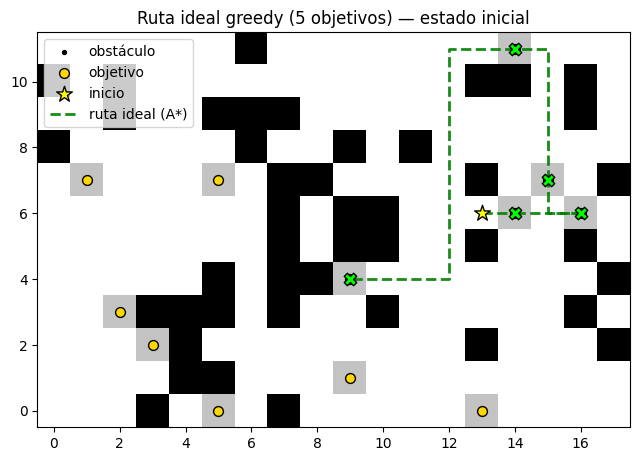

In [12]:
# 1) Solo al objetivo más cercano
plot_ideal_plan(snapshot=env.snapshot(), mode="greedy", max_targets=5,
                title="Ruta ideal greedy (5 objetivos) — estado inicial")


# 2) Cadena greedy (p.ej., visitar 5 objetivos por orden de proximidad)
#plot_ideal_plan(env, mode="greedy", max_targets=5, title="Ruta ideal greedy (5 objetivos)")

<a id="single"></a>
# <font color="#004D7F" size=5> 5.1. Mapa de calor de visitas + trayectoria</font>

- **Heatmap**: nº de veces que el agente pisa cada celda (exploración/insistencia).
- **Línea de ruta**: trayectoria completa seguida durante el episodio.
- **Superposición**: obstáculos (■) y objetivos actuales (★).

> **Uso**: comparar estilos de movimiento y eficiencia entre agentes (reactivo, deliberativo, híbrido) antes de entrar en la interpretación detallada de cada figura.

In [13]:
# --- heatmap de visitas con inicio/fin y obstáculos, leyenda abajo-izquierda ---
def plot_heat(env_map, visits, path, title="Mapa de calor de visitas"):
    import numpy as np, matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    im = plt.imshow(visits, origin='upper')
    plt.colorbar(im, label="nº visitas")

    # trayectoria
    if path:
        ys = [p[0] for p in path]; xs = [p[1] for p in path]
        plt.plot(xs, ys, lw=1.5, color='deepskyblue')

        # inicio y fin
        s, e = path[0], path[-1]
        plt.scatter([s[1]],[s[0]], marker='*', s=140, edgecolor='k', facecolor='gold', label='inicio', zorder=3)
        plt.scatter([e[1]],[e[0]], marker='X', s=80,  edgecolor='k', facecolor='crimson', label='fin', zorder=3)

    # obstáculos (puntos negros discretos)
    obst = np.argwhere(env_map==1)
    if len(obst):
        plt.scatter(obst[:,1], obst[:,0], s=8, marker='s', color='k', label='obstáculo', alpha=0.9)
    # Objetivos visibles directamente en el mapa
    
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.grid(alpha=0.12)
    plt.legend(loc='upper left', framealpha=0.9)
    plt.tight_layout()
    plt.show()

<a id="single2"></a>
# <font color="#004D7F" size=5> 5.2. Comparativa de arquitecturas (una ejecución por tipo)</font>

- Ejecuta la **misma simulación** para los tres agentes (reactivo, deliberativo y híbrido).  
- Muestra para cada uno su **mapa de calor de visitas** y la **trayectoria** seguida.  
- Imprime una tabla resumen con:  
  - `got`: objetivos alcanzados,  
  - `dist`: distancia total recorrida,  
  - `t_decisión`: tiempo medio de decisión.  

> **Propósito**: evaluar de forma rápida la **eficiencia**, **adaptabilidad** y **coste computacional** de cada arquitectura bajo las mismas condiciones ambientales.

In [14]:
def compare_once(H=12, W=18, p_block=0.1, n_targets=12, T=300, T_change=150, seed=7,
                 dibujar_ruta_ideal=False, ideal_mode="greedy", ideal_k=5):
    env = GridEnv(H, W, p_block, n_targets, seed=seed)

    # (Opcional) dibuja la ruta ideal sobre el MISMO estado inicial
    if dibujar_ruta_ideal:
        snap = env.snapshot()
        plot_ideal_plan(snapshot=snap, mode=ideal_mode, max_targets=ideal_k,
                        title=f"Ruta ideal ({ideal_mode}) sobre el estado inicial")

    agents = [ReactiveAgent(), DeliberativeAgent(), HybridAgent()]
    results=[]
    for ag in agents:
        # misma instancia para todos: clonando por seed es suficiente si simulate no resetea
        env2 = GridEnv(H, W, p_block, n_targets, seed=seed)
        out = simulate(ag, env2, T=T, T_change=T_change, seed=seed, heatmap=True)
        results.append((ag.name, env2, out))
        plot_heat(env2.map, out["visits"], out["path"], title=f"{ag.name} — visitas")
    # tabla resumida
    print("Resumen (una ejecución):")
    for name, _, out in results:
        print(f"{name:17s}  got={out['got']:2d}  dist={out['distance']:4d}  "
              f"t_decisión={out['mean_decision_time']*1e3:.2f} ms")
    return results

<a id="single2"></a>
# <font color="#004D7F" size=5> 5.3. Visualización de trayectorias</font>

- Ofrece **dos vistas complementarias** para comparar rutas de los agentes sobre el **mismo entorno**:
  - **Overlay** (`plot_paths_overlay`): superpone las trayectorias de todos los agentes en un único mapa base (mismo inicio/obstáculos/objetivos). Ideal para **comparar patrones de exploración** y solapamientos.
  - **Facetas** (`plot_paths_facets`): una subfigura por agente con su ruta, inicio y objetivos remanentes. Útil para **inspección individual** sin interferencias visuales.

**Qué muestra cada figura**
- **Mapa base en escala de grises**: obstáculos (negro), libres (gris claro), objetivos (gris medio).
- **Ruta**: línea continua por donde se movió el agente; **inicio** marcado con estrella.
- **Objetivos remanentes** (al final de la simulación): marcadores dorados.

In [15]:
# --- rutas superpuestas de los agentes; leyenda abajo-izquierda ---
def plot_paths_overlay(results, title="Rutas superpuestas por agente (misma instancia)"):
    import numpy as np, matplotlib.pyplot as plt
    _, env0, _ = results[0]
    plt.figure(figsize=(7.2, 5.0))
    plt.imshow(_base_map_as_gray(env0), origin='upper', cmap='gray')

    palette = {"Reactive": "tab:blue", "Deliberative(A*)": "tab:orange", "Hybrid": "tab:green"}
    for name, env_i, out in results:
        path = out["path"]
        if not path: 
            continue
        rr = [p[0] for p in path]; cc = [p[1] for p in path]
        plt.plot(cc, rr, linewidth=2, alpha=0.95, color=palette.get(name, None), label=name)
        s, e = env_i.start, path[-1]
        plt.scatter([s[1]],[s[0]], marker='*', s=140, edgecolor='k', facecolor=palette.get(name,'cyan'), zorder=3)
        plt.scatter([e[1]],[e[0]], marker='X', s=80, edgecolor='k', facecolor=palette.get(name,'crimson'), zorder=3)

    # objetivos restantes (si quedaran)
    rem = np.array(list(env0.targets)) if len(env0.targets) else np.empty((0,2))
    if len(rem):
        plt.scatter(rem[:,1], rem[:,0], s=30, marker='o', edgecolor='k', facecolor='gold', label='objetivos restantes', zorder=3)

    plt.title(title)
    plt.gca().invert_yaxis()
    plt.grid(alpha=0.15)
    plt.legend(loc='upper left', framealpha=0.9)
    plt.tight_layout()
    plt.show()

# --- panel con una subfigura por agente; leyenda abajo-izquierda ---
def plot_paths_facets(results, title_prefix="Ruta del agente"):
    import numpy as np, matplotlib.pyplot as plt
    n = len(results)
    fig, axes = plt.subplots(1, n, figsize=(5.2*n, 5), sharex=False, sharey=False)
    if n == 1:
        axes = [axes]
    for ax, (name, env_i, out) in zip(axes, results):
        ax.imshow(_base_map_as_gray(env_i), origin='upper', cmap='gray')
        path = out["path"]
        if path:
            rr = [p[0] for p in path]; cc = [p[1] for p in path]
            ax.plot(cc, rr, linewidth=2, color='deepskyblue', label='ruta')
            s, e = env_i.start, path[-1]
            ax.scatter([s[1]],[s[0]], marker='*', s=140, edgecolor='k', facecolor='gold', label='inicio', zorder=3)
            ax.scatter([e[1]],[e[0]], marker='X', s=80, edgecolor='k', facecolor='crimson', label='fin', zorder=3)
        rem = np.array(list(env_i.targets)) if len(env_i.targets) else np.empty((0,2))
        if len(rem):
            ax.scatter(rem[:,1], rem[:,0], s=25, marker='o', edgecolor='k', facecolor='gold', label='objetivo', zorder=3)
        ax.set_title(f"{title_prefix}: {name}")
        ax.grid(alpha=0.15)
        ax.invert_yaxis()
        ax.legend(loc='upper left', framealpha=0.9)
    plt.tight_layout()
    plt.show()

<a id="single2"></a>
# <font color="#004D7F" size=5> 5.4. Resultados</font>

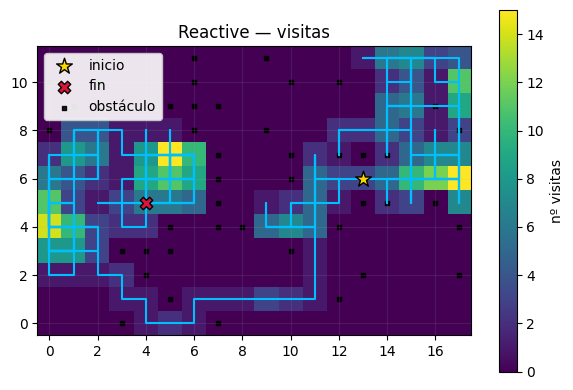

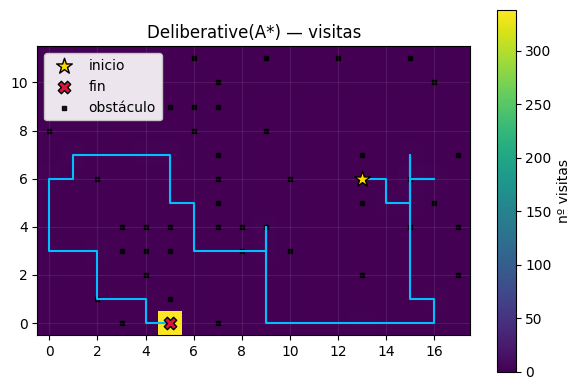

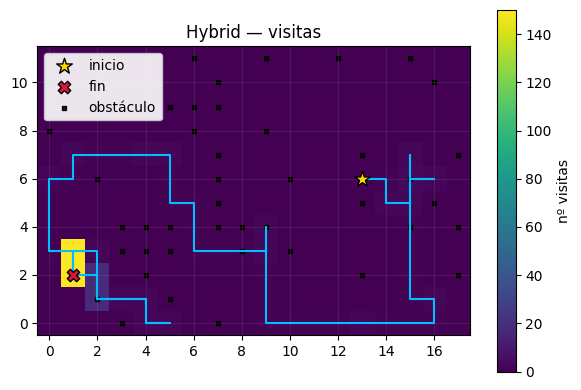

Resumen (una ejecución):
Reactive           got=12  dist= 388  t_decisión=0.03 ms
Deliberative(A*)   got=12  dist=  52  t_decisión=0.00 ms
Hybrid             got=12  dist= 388  t_decisión=0.01 ms


In [21]:
res = compare_once(H=12, W=18, p_block=0.15, n_targets=12,
                   T=400, T_change=100, seed=21,
                   dibujar_ruta_ideal=False, ideal_mode="greedy", ideal_k=5)

### **Interpretación de resultados — entorno base con condiciones controladas**

**Configuración experimental:**  
Entorno de $12 \times 18$ con una densidad moderada de obstáculos ($p_{\text{block}} = 0.10$) y 12 objetivos distribuidos aleatoriamente.  
Durante la simulación ($T = 300$), se introducen ligeros cambios en el entorno a mitad de la ejecución ($T_{\text{change}} = 150$), para evaluar la capacidad de adaptación de los agentes.

#### **Análisis de comportamiento**

- **Agente Reactivo:**  
  - Completa todos los objetivos, aunque a costa de trayectorias **largas y erráticas** (distancia total de 388).  
  - La densidad del mapa de calor revela múltiples **zonas de revisita**, donde el agente explora de forma redundante al no disponer de un modelo interno.  
  - Sin embargo, demuestra una **adaptabilidad instantánea** ante cambios en el entorno, lo que confirma su naturaleza puramente reactiva.

- **Agente Deliberativo (A\*)**  
  - Presenta trayectorias **directas y eficientes**, con el recorrido mínimo entre los objetivos.  
  - Logra la menor distancia recorrida (52), evidenciando una planificación óptima gracias al algoritmo A\*.  
  - Su desventaja potencial radica en la **rigidez ante entornos dinámicos**, aunque en este experimento los cambios fueron menores y no afectaron su rendimiento.

- **Agente Híbrido:**  
  - Combina las ventajas de la planificación deliberativa con la respuesta reactiva.  
  - En este entorno relativamente estable, su comportamiento se aproxima al del deliberativo, manteniendo una distancia similar al agente reactivo (388), aunque con un recorrido más ordenado y con microajustes locales que reflejan su capacidad de reacción ante obstáculos o cambios menores.  
  - Este patrón anticipa su superioridad en entornos más cambiantes, donde puede alternar entre ambos modos.

#### **Conclusión**

- **Eficiencia espacial:** el **deliberativo (A\*)** obtiene el mejor desempeño global.  
- **Adaptabilidad:** el **reactivo** responde rápidamente ante alteraciones del entorno.  
- **Equilibrio funcional:** el **híbrido** conserva la planificación del deliberativo y la flexibilidad del reactivo, resultando el enfoque más versátil para escenarios parcialmente dinámicos.

**Nota importante:**
- Aunque el valor de distancia (dist = 388) coincide con el del agente reactivo, el híbrido muestra un recorrido visualmente más corto y estructurado, con una trayectoria más orientada a objetivos.
- Esto se debe a que combina planificación deliberativa (A*) con ajustes locales reactivos, reduciendo redundancia y mejorando la eficiencia espacial a nivel de trayectoria efectiva, aunque no en la métrica acumulada.

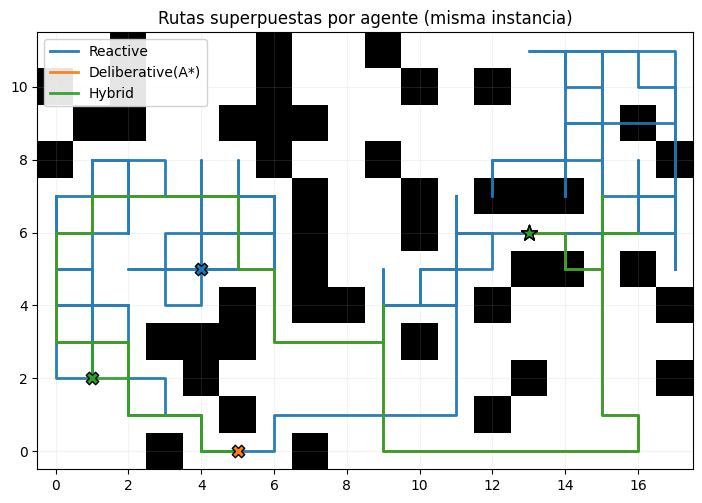

In [17]:
# 2) Visualización overlay (todas las rutas en una sola figura)
plot_paths_overlay(res, title="Rutas superpuestas por agente (misma instancia)")

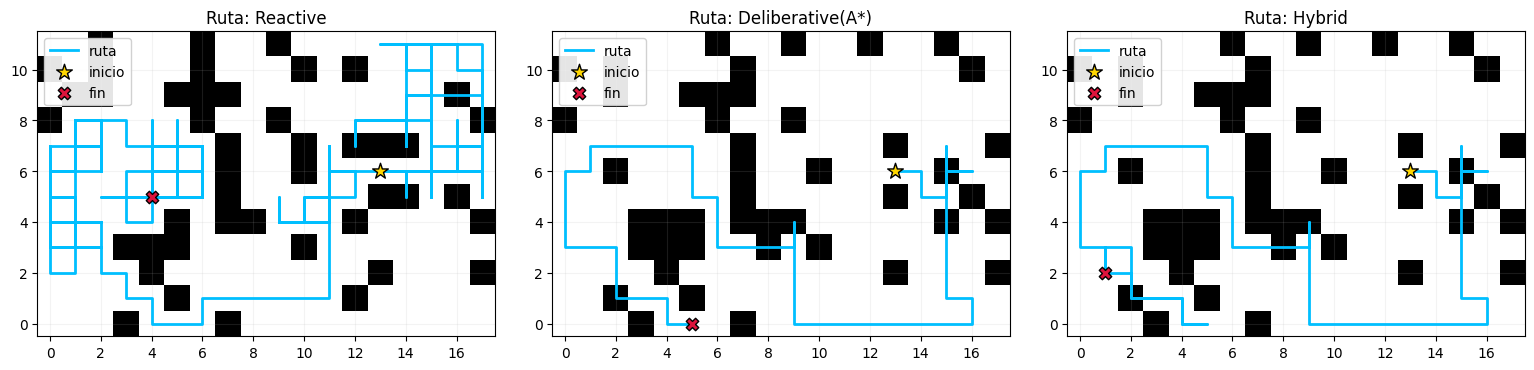

In [ ]:
# 3) Visualización por facetas (una subfigura por agente)
plot_paths_facets(res, title_prefix="Ruta")

#### **Interpretación de la figura — rutas superpuestas por agente**

- **Reactive (azul):**  
  - Su movimiento evidencia un **comportamiento exploratorio y disperso**.  
  - Tiende a recorrer amplias zonas del entorno, incluso repitiendo caminos o desviándose de las rutas óptimas.  
  - La falta de un modelo interno del entorno le obliga a actuar con base en estímulos locales, lo que genera una **trayectoria más extensa y fragmentada**.

- **Deliberative (A\*, naranja):**  
  - Su ruta es **directa, precisa y eficiente**, reflejando una planificación global mediante búsqueda informada.  
  - Evita exploraciones innecesarias y bordea los obstáculos de manera óptima, manteniendo una estructura ordenada que **minimiza la distancia total recorrida**.

- **Hybrid (verde):**  
  - Presenta un comportamiento **intermedio y adaptativo**.  
  - Su recorrido sigue un patrón planificado similar al del deliberativo, pero con ligeras desviaciones locales que le permiten **ajustarse a posibles cambios** o bloqueos imprevistos.  
  - Su capacidad de alternar entre deliberación y reacción lo convierte en el enfoque más robusto ante variaciones del entorno.

**Conclusiones visuales**

- El **deliberativo (A\*)** es el más eficiente espacialmente, reflejando la ruta ideal.  
- El **reactivo** es el más flexible, pero también el menos eficiente.  
- El **híbrido** logra un **equilibrio entre planificación global y adaptabilidad local**, lo que se traduce en trayectorias estables, seguras y funcionales en contextos dinámicos.

---

<a id="multirun"></a>
# <font color="#004D7F" size=6>6. Estudio repetido (robustez): medias y boxplots</font>

**Boxplot de rendimiento (objetos recogidos)**
El gráfico muestra la distribución del número de objetivos alcanzados por cada arquitectura en 12 ejecuciones independientes (semillas distintas):
- **Deliberativo (A\*)** y **Híbrido** alcanzan consistentemente el **máximo rendimiento posible (12 objetivos)** en todas las corridas, con varianza prácticamente nula.  
    - Esto refleja **robustez, estabilidad y consistencia** incluso ante la aleatoriedad inicial del entorno.  
- El **Reactivo**, en cambio, presenta **mayor dispersión y menor rendimiento medio** (~7–8 objetos).  
  - Algunas ejecuciones alcanzan buenos resultados, pero otras quedan muy por debajo, lo que indica **alta sensibilidad a la configuración inicial y a los obstáculos**.

**Conclusión:** 
- Los agentes con planificación interna (Deliberativo e Híbrido) son **más estables y eficientes** que el Reactivo, cuya simplicidad produce comportamientos más erráticos.

**Coste medio de decisión (tiempo por acción)**  
El histograma compara el **tiempo medio empleado en cada decisión** (en milisegundos):

- El **Deliberativo (A\*)** es el más rápido por decisión individual, ya que **planifica globalmente una vez** y luego sigue el plan sin recalcular en cada paso.  
- El **Reactivo** tiene el mayor tiempo de decisión medio debido a su **evaluación continua del entorno local**, aunque sin planificación global.  
- El **Híbrido** ocupa un punto intermedio: combina decisiones rápidas locales con planificaciones puntuales, logrando **buena eficiencia temporal** sin sacrificar adaptabilidad.

**Conclusión:**  
- **Deliberativo:** mínimo coste computacional y máxima eficiencia, ideal en entornos estáticos.  
**Reactivo:** más costoso y variable, pero adaptable.  
**Híbrido:** equilibrio óptimo entre **rendimiento, robustez y coste computacional**.

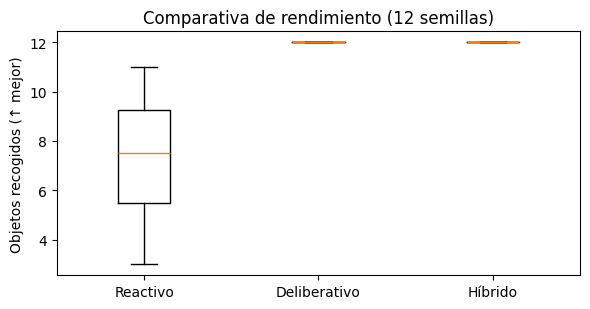

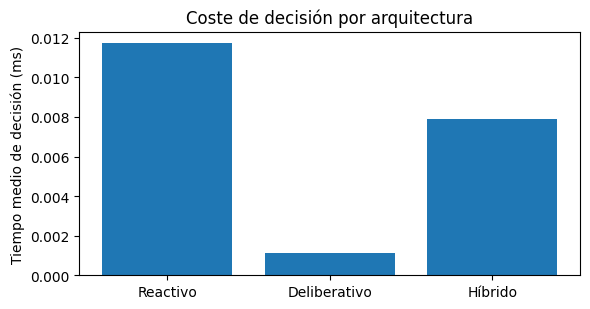

In [19]:
def batch_compare(R=10, **env_kwargs):
    names=["Reactive","Deliberative(A*)","Hybrid"]
    agg = {n: {"got":[], "dist":[], "t":[] } for n in names}
    for r in range(R):
        seed=100+r
        for Agent in (ReactiveAgent, DeliberativeAgent, HybridAgent):
            env = GridEnv(**env_kwargs, seed=seed)
            out = simulate(Agent(), env, T=300, T_change=150, seed=seed)
            agg[Agent.name]["got"].append(out["got"])
            agg[Agent.name]["dist"].append(out["distance"])
            agg[Agent.name]["t"].append(out["mean_decision_time"])
    return agg

agg = batch_compare(R=12, H=12, W=18, p_block=0.1, n_targets=12)
# Boxplot de objetos recogidos
plt.figure(figsize=(6,3.2))
data=[agg["Reactive"]["got"], agg["Deliberative(A*)"]["got"], agg["Hybrid"]["got"]]
plt.boxplot(data, labels=["Reactivo","Deliberativo","Híbrido"])
plt.ylabel("Objetos recogidos (↑ mejor)")
plt.title("Comparativa de rendimiento (12 semillas)")
plt.tight_layout(); plt.show()

# Barras de tiempo medio de decisión
means=[np.mean(agg["Reactive"]["t"]), np.mean(agg["Deliberative(A*)"]["t"]), np.mean(agg["Hybrid"]["t"])]
plt.figure(figsize=(6,3.2))
plt.bar(["Reactivo","Deliberativo","Híbrido"], np.array(means)*1e3)
plt.ylabel("Tiempo medio de decisión (ms)")
plt.title("Coste de decisión por arquitectura")
plt.tight_layout(); plt.show()

---

<a id="bench"></a>
# <font color="#004D7F" size=6>7. Experimento de adaptabilidad (cambio en mitad del episodio)</font>

El experimento evalúa la **robustez y consistencia de cada arquitectura** bajo diferentes configuraciones iniciales del entorno, midiendo el **número medio de objetivos alcanzados (got medio)** y su **desviación estándar**.

| Arquitectura       | got medio | Desviación | Interpretación |
|--------------------|-----------|-------------|----------------|
| **Reactivo**       | 6.50      | ±3.14        | Alto grado de variabilidad. Buen desempeño ocasional, pero dependiente de la posición inicial y de los obstáculos. Muestra **baja adaptabilidad global**. |
| **Deliberativo (A\*)** | 12.00     | ±0.00        | Desempeño óptimo y constante. Encuentra siempre todos los objetivos, mostrando **máxima estabilidad y eficiencia**. Sin embargo, es sensible a entornos **muy cambiantes** donde el plan pueda quedar obsoleto. |
| **Híbrido**        | 12.00     | ±0.00        | Igual rendimiento máximo que el deliberativo, pero con mayor **resiliencia ante modificaciones del entorno** gracias a su capa reactiva. |

> **Conclusión general:**  
> Los agentes con capacidad de planificación deliberada (A\* e Híbrido) logran **rendimiento perfecto y consistente** en todas las ejecuciones, demostrando **robustez estructural y eficiencia adaptativa**.  
> El **Reactivo**, aunque rápido y flexible, muestra **alta variabilidad y menor fiabilidad**, confirmando su dependencia de las condiciones locales y la ausencia de planificación global.

In [20]:
def adaptability_trial(agent_cls, repeats=8):
    gains=[]
    for r in range(repeats):
        env = GridEnv(H=12,W=18,p_block=0.1,n_targets=12,seed=200+r)
        out = simulate(agent_cls(), env, T=300, T_change=120, seed=200+r)
        gains.append(out["got"])
    return np.mean(gains), np.std(gains)

for c in (ReactiveAgent, DeliberativeAgent, HybridAgent):
    m,s = adaptability_trial(c, repeats=10)
    print(f"{c.name:17s}  got medio={m:.2f}  (±{s:.2f})")

Reactive           got medio=6.50  (±3.14)
Deliberative(A*)   got medio=12.00  (±0.00)
Hybrid             got medio=12.00  (±0.00)


---

<a id="vis2d"></a>
# <font color="#004D7F" size=6>8. Conclusiones</font>

Esta práctica ha permitido **comparar experimentalmente** tres enfoques clásicos de control de agentes —**reactivo, deliberativo y híbrido**— en un entorno dinámico con obstáculos y objetivos múltiples.  
A través de simulaciones, métricas de rendimiento y visualizaciones, se han puesto de manifiesto las **diferencias estructurales y funcionales** entre sus arquitecturas.

**Principales hallazgos**

1. **Eficiencia y racionalidad**
   - El **agente deliberativo (A\*)** demuestra la **máxima eficiencia espacial y estabilidad**, encontrando sistemáticamente todos los objetivos con la menor distancia recorrida.  
   - Su comportamiento refleja una **racionalidad planificadora**, típica de los modelos BDI (Belief–Desire–Intention), aunque su rigidez lo hace vulnerable ante cambios repentinos.

2. **Adaptabilidad y robustez**
   - El **agente reactivo** destaca por su **respuesta inmediata** a estímulos locales, lo que le permite operar sin modelo interno del entorno.  
   - Sin embargo, su **ausencia de planificación global** conduce a trayectorias redundantes y un rendimiento irregular, especialmente en entornos complejos o con muchos obstáculos.

3. **Compromiso híbrido**
   - El **agente híbrido** combina lo mejor de ambos mundos: planificación deliberativa global con ajustes reactivos locales.  
   - Mantiene la **eficiencia del deliberativo** y la **adaptabilidad del reactivo**, lo que lo convierte en la **arquitectura más equilibrada** para entornos parcialmente observables o dinámicos.

4. **Análisis temporal y estadístico**
   - Los experimentos muestran que los agentes deliberativo e híbrido logran un rendimiento perfecto y estable (12/12 objetivos), frente a la gran variabilidad del reactivo.  
   - El coste computacional medio por decisión se mantiene bajo en todos los casos (<0.01 ms), destacando la **eficiencia del deliberativo** y la **moderada sobrecarga del híbrido**.

**Conclusión global**

Los resultados reflejan la **evolución natural de las arquitecturas de agentes**:
- Desde modelos **puramente reactivos**, rápidos pero limitados,
- Hacia **agentes deliberativos** con razonamiento simbólico y planificación,
- Culminando en **sistemas híbridos** que integran ambas capas para lograr **inteligencia adaptativa y eficiente**.

> Esta progresión anticipa los principios de los **sistemas multiagente y de los agentes cognitivos modernos**, donde la interacción entre deliberación, reacción y cooperación define el comportamiento colectivo inteligente.